<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [0]:
filename=f'/content/drive/My Drive/FB friend recommendation/data/fea_sample/storage_sample_stage4.h5'

#reading
from pandas import read_hdf
df_final_train = read_hdf(filename, 'train_df',mode='r')
df_final_test = read_hdf(filename, 'test_df',mode='r')

In [4]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

In [0]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [6]:
filename = f'/content/drive/My Drive/FB friend recommendation/data/after_eda/train_pos_after_eda.csv'
if os.path.isfile(filename):
    train_graph=nx.read_edgelist(filename ,delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
else:
    print("please run the FB_EDA.ipynb or download the files from drive")

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399


<h1> Preferential Attachment</h1>
<h5>The score is the multiplication of no. of friends/neighbors/connections of both the nodes.<br>
In this case-
Score(x,y) = no. of followers and followees(x) * no. of followers and followees(y)</h5>


In [0]:
def pref_attachment(a,b):
    try:
        f_a = len(set(train_graph.successors(a)).union(set(train_graph.predecessors(a)))) #stores #friends of a
        f_b = len(set(train_graph.successors(b)).union(set(train_graph.predecessors(b)))) #stores #friends of b
        score = f_a * f_b
    except:
        return 0
    return score


In [0]:
#adding preferential attachment in train and test data
df_final_train['preferential_attachment'] = df_final_train.apply(lambda row: pref_attachment(row['source_node'], row['destination_node']),axis=1)
df_final_test['preferential_attachment'] = df_final_test.apply(lambda row: pref_attachment(row['source_node'], row['destination_node']),axis=1)


In [9]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'preferential_attachment'],
      dtype='object')

<h1> Adding svd.dot features</h1>


In [18]:
a =pd.DataFrame([[1,2,3,4],[1,2,3,4]])
b =pd.DataFrame([[1,2,3,4],[1,2,3,4]])

lst=[]
for row in range(2):
  total = 0
  for col in range(4):
    total+= a.loc[row][col] * b.loc[row][col]
  lst.append(total)
  print(total)

30
30


In [0]:
#since np.dot(a,b) was consistently leading to crashing of sessions, i've proceeded with for loops

a = df_final_train[['svd_u_s_1','svd_u_s_2','svd_u_s_3','svd_u_s_4','svd_u_s_5','svd_u_s_6']]
b = df_final_train[['svd_u_d_1','svd_u_d_2','svd_u_d_3','svd_u_d_4','svd_u_d_5','svd_u_d_6']]



lst=[]
for row in range(100002):
  total = 0
  for col in range(6):
    total+= a.loc[row][col] * b.loc[row][col]
  lst.append(total)

In [0]:
df_final_train['svd_dot_u'] = pd.DataFrame(lst)

In [0]:
a = df_final_train[['svd_v_s_1','svd_v_s_2','svd_v_s_3','svd_v_s_4','svd_v_s_5','svd_v_s_6']]
b = df_final_train[['svd_v_d_1','svd_v_d_2','svd_v_d_3','svd_v_d_4','svd_v_d_5','svd_v_d_6']]


lst=[]
for row in range(100002):
  total = 0
  for col in range(6):
    total+= a.loc[row][col] * b.loc[row][col]
  lst.append(total)

In [0]:
df_final_train['svd_dot_v'] = pd.DataFrame(lst)

In [23]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'preferential_attachment', 'svd_dot_u', 'svd_dot_v'],
      dtype='object')

In [0]:
a = df_final_test[['svd_u_s_1','svd_u_s_2','svd_u_s_3','svd_u_s_4','svd_u_s_5','svd_u_s_6']]
b = df_final_test[['svd_u_d_1','svd_u_d_2','svd_u_d_3','svd_u_d_4','svd_u_d_5','svd_u_d_6']]



lst=[]
for row in range(50002):
  total = 0
  for col in range(6):
    total+= a.loc[row][col] * b.loc[row][col]
  lst.append(total)

df_final_test['svd_dot_u'] = pd.DataFrame(lst)

In [0]:
a = df_final_test[['svd_v_s_1','svd_v_s_2','svd_v_s_3','svd_v_s_4','svd_v_s_5','svd_v_s_6']]
b = df_final_test[['svd_v_d_1','svd_v_d_2','svd_v_d_3','svd_v_d_4','svd_v_d_5','svd_v_d_6']]


lst=[]
for row in range(50002):
  total = 0
  for col in range(6):
    total+= a.loc[row][col] * b.loc[row][col]
  lst.append(total)

df_final_test['svd_dot_v'] = pd.DataFrame(lst)

In [26]:
df_final_test.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'preferential_attachment', 'svd_dot_u', 'svd_dot_v'],
      dtype='object')

In [0]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

In [28]:
print(df_final_train.shape)
print(y_train.shape)
print(df_final_test.shape)
print(y_test.shape)

(100002, 54)
(100002,)
(50002, 54)
(50002,)


<H1> ML MODELS

Estimators =  10 Train Score 0.9099807176391683 test Score 0.899001438605399
Estimators =  50 Train Score 0.9196694422098478 test Score 0.9146044794899757
Estimators =  100 Train Score 0.9203002181696713 test Score 0.9146857837588563
Estimators =  250 Train Score 0.9218940968776442 test Score 0.9166002433192096
Estimators =  450 Train Score 0.922040202265034 test Score 0.9169569048718057


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

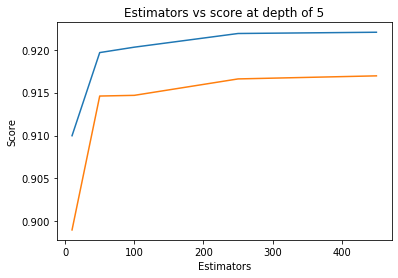

In [29]:
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.8793873509459402 test Score 0.8650240000000001
depth =  9 Train Score 0.9567158246618902 test Score 0.9235075019465079
depth =  11 Train Score 0.9601692071465615 test Score 0.9244536151934981
depth =  15 Train Score 0.9630110976860361 test Score 0.925988296215215
depth =  20 Train Score 0.9637689994310331 test Score 0.9266165223437204
depth =  35 Train Score 0.9637614166268758 test Score 0.9264829794405123
depth =  50 Train Score 0.9637614166268758 test Score 0.9264829794405123
depth =  70 Train Score 0.9637614166268758 test Score 0.9264829794405123
depth =  130 Train Score 0.9637614166268758 test Score 0.9264829794405123


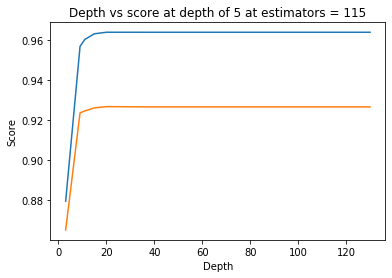

In [30]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

In [0]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.96225043 0.96215493 0.96057081 0.96194015 0.96330005]
mean train scores [0.96294922 0.96266735 0.96115674 0.96263457 0.96430539]


In [0]:
print(rf_random.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)


In [0]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

In [0]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [0]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9652533106548414
Test f1 score 0.9241678239279553


In [0]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


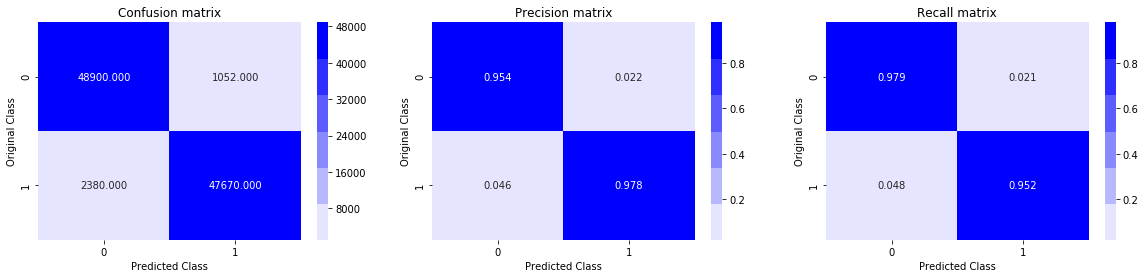

Test confusion_matrix


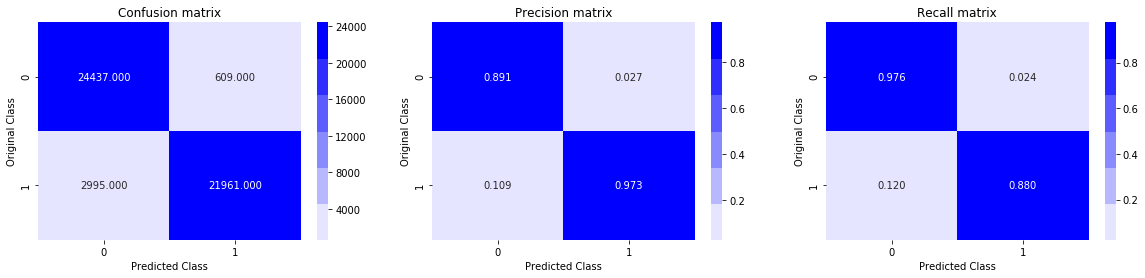

In [0]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

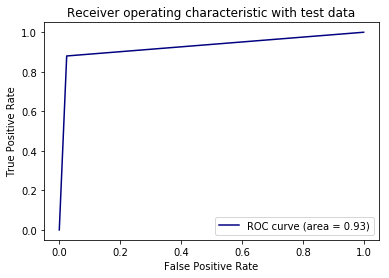

In [0]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

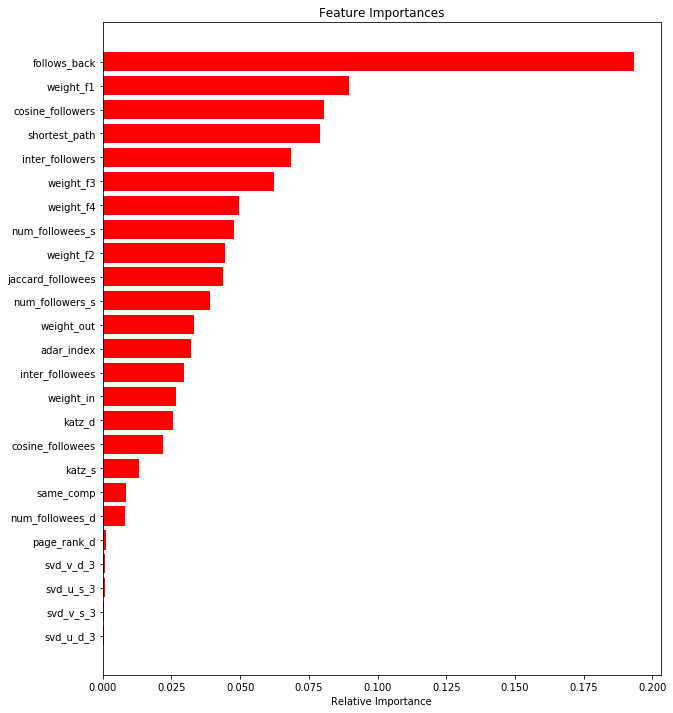

In [0]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

<H1> XGBOOST

In [0]:
import xgboost as xgb

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score


In [0]:
 def predict_prob(clf, data): 
        y_data_pred = []
        y_data_pred.extend(clf.predict_proba(data)[:,1]) 
        
        return y_data_pred

In [35]:
print(df_final_train.shape)
print(y_train.shape)
print(df_final_test.shape)
print(y_test.shape)

(100002, 54)
(100002,)
(50002, 54)
(50002,)



Your model is overfitting.

Could you please try changing parameters

  params = {"n_estimators":sp_randint(95,125),
 "max_depth": sp_randint(5,15),}  

Try randomserchCV, please use scoring = 'f1'

In [0]:
from scipy.stats import randint as sp_randint


params = {"n_estimators":sp_randint(95,125), 
          "max_depth": sp_randint(5,15)} 

In [0]:
xgb_model = xgb.XGBClassifier(random_state=25,n_jobs=-1, learning_rate=0.02)

In [0]:
from sklearn.model_selection import RandomizedSearchCV

rs_clf = RandomizedSearchCV(xgb_model, params,
                            n_iter=5,cv=10,scoring='f1',random_state=25)

In [39]:
rs_clf.fit(df_final_train, y_train)

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.02, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=-1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=25, reg_alp...
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='warn', n_iter=5, n_jobs=None,
                   param_distri

In [40]:
rs_clf.cv_results_

{'mean_fit_time': array([ 72.85198648,  85.91794662,  57.50453846, 104.95815856,
         72.53631783]),
 'mean_score_time': array([0.05638113, 0.07151451, 0.04157557, 0.08314652, 0.05512657]),
 'mean_test_score': array([0.97459114, 0.97605136, 0.97272432, 0.97686993, 0.97459207]),
 'param_max_depth': masked_array(data=[9, 11, 7, 13, 9],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[121, 118, 124, 123, 120],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 9, 'n_estimators': 121},
  {'max_depth': 11, 'n_estimators': 118},
  {'max_depth': 7, 'n_estimators': 124},
  {'max_depth': 13, 'n_estimators': 123},
  {'max_depth': 9, 'n_estimators': 120}],
 'rank_test_score': array([4, 2, 5, 1, 3], dtype=int32),
 'split0_test_score': array([0.97410479, 0.97555062, 0.97225328, 0.97628897, 0.97410479]),
 'split1_t

In [41]:
print('mean test scores',rs_clf.cv_results_['mean_test_score'])

mean test scores [0.97459114 0.97605136 0.97272432 0.97686993 0.97459207]


In [42]:
rs_clf.best_score_


0.9768699262520999

In [43]:
best_params = rs_clf.best_params_
best_params

{'max_depth': 13, 'n_estimators': 123}

In [0]:
d_train = xgb.DMatrix(df_final_train, label = y_train) 
d_test = xgb.DMatrix(df_final_test, label = y_test) 

In [0]:
watchlist = [(d_train, 'train'), (d_test, 'valid')] 

In [46]:
bst = xgb.train(best_params, d_train, 200, watchlist, early_stopping_rounds=10, verbose_eval=10) 

[0]	train-rmse:0.361075	valid-rmse:0.379035
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 10 rounds.
[10]	train-rmse:0.080219	valid-rmse:0.240988
Stopping. Best iteration:
[6]	train-rmse:0.102238	valid-rmse:0.238168



In [0]:
y_train_pred = bst.predict(d_train)
y_test_pred  = bst.predict(d_test)

In [48]:
from sklearn.metrics import f1_score

#as xgboost only returns probability values i'd to round the values to get 1/0
print('Train f1 score',f1_score(y_train,y_train_pred.round())) 
print('Test f1 score',f1_score(y_test,y_test_pred.round()))

Train f1 score 0.997307549870382
Test f1 score 0.9322658801221954


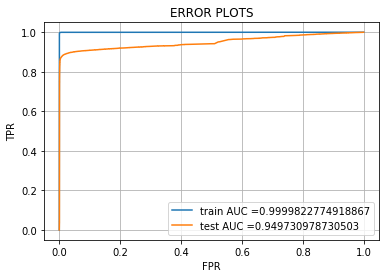

In [49]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred) 
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr))) 
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR") 
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [0]:
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
# (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould): 
    predictions = []
    for i in proba:
        if i>=threshould: 
            predictions.append(1)
        else: 
            predictions.append(0)
    return predictions

In [51]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

the maximum value of tpr*(1-fpr) 0.9963831604014179 for threshold 0.403


Train confusion_matrix


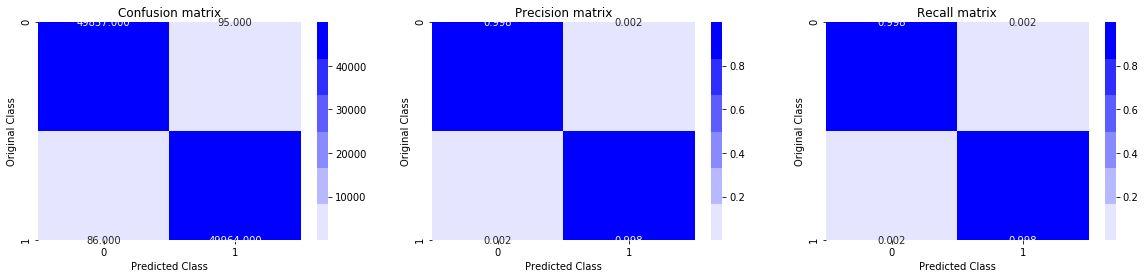

Test confusion_matrix


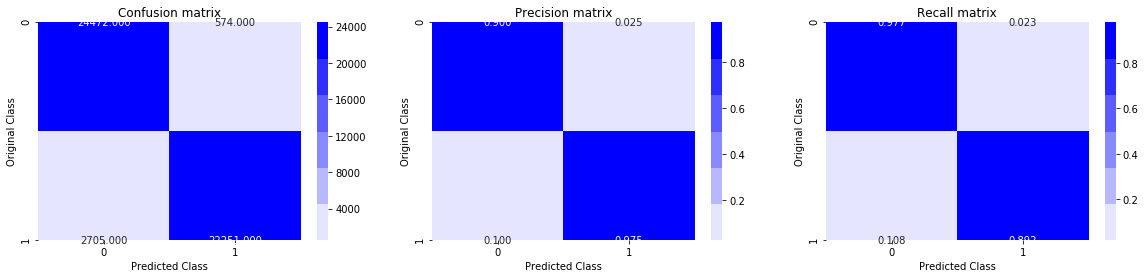

In [57]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,predict_with_best_t(y_train_pred, best_t))
print('Test confusion_matrix')
plot_confusion_matrix(y_test,predict_with_best_t(y_test_pred, best_t))

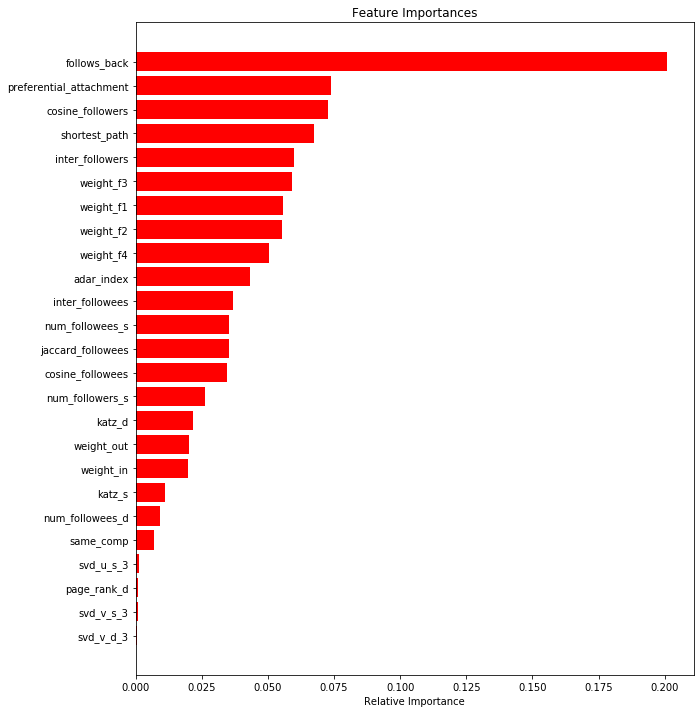

In [54]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Preferential Attachment tends to be an important feature while svd_dot values play very little role

<h1> Summary

1. This was a link prediction problem where only the souce node and destination node was given.
2. Feature Engineering was the most important part of this case study, so a lot of features was thought of and calculated
3. Jaccard Distance, cosine distance, page rank, shortest path,adar index,kartz centrality, hits score preferential attachment, svd score and dot product of svd scores- were calcluated and were considered ass features.
4. Models were trained using F1 score as the performance metric (as the primary requirement was to get high precison and recall values)
